In [1]:
import tensorflow as tf
import pandas as pd
import cv2
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, InputLayer, MaxPooling2D, RandomFlip, RandomRotation, Lambda, Layer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv("/content/drive/MyDrive/hackaton_deforestation/train.csv")

## Split the data

In [4]:
X_train, X_val, y_train, y_val = train_test_split(data['example_path'], data['label'], test_size = 0.3, random_state = 20, stratify = data['label'])

In [7]:
data['label'].value_counts()
# the data is imbalanced

0    860
2    658
1    196
Name: label, dtype: int64

## Load the images

In [5]:
PATH = '/content/drive/MyDrive/hackaton_deforestation/'

images_train = []
images_val = []

# Read image
for image_file in X_train:
  path = PATH + image_file
  img = cv2.imread(path)
  images_train.append(img)

for image_file in X_val:
  path = PATH + image_file
  img = cv2.imread(path)
  images_val.append(img)

In [6]:
X_train = np.array(images_train)
X_val = np.array(images_val)

y_train = to_categorical(y_train, num_classes = 3)
y_val = to_categorical(y_val, num_classes = 3)

In [ ]:
X_train.shape

## Visualize images

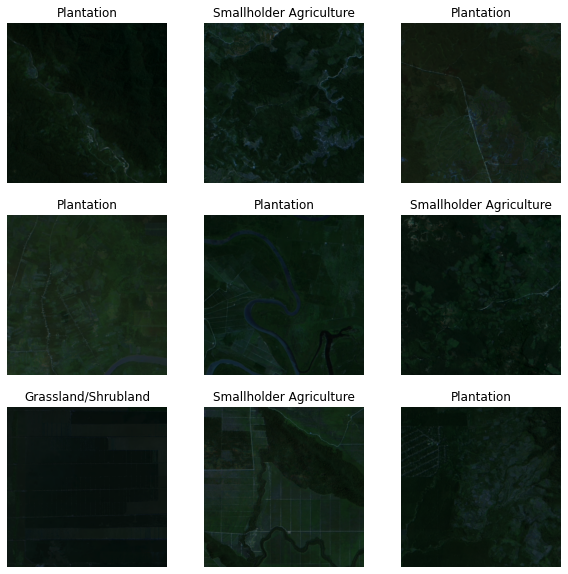

In [11]:
classnames = {
    0 : 'Plantation',
    1: 'Grassland/Shrubland',
    2: 'Smallholder Agriculture'
}
temp = 0
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train[i].astype("uint8"))
  plt.title(classnames[data['label'][i]])
  plt.axis("off")

## Data augmentation

### Possible transformations

In [ ]:
i = 0
X_train_transformed = []
for img in X_train:
  canny = cv2.Canny(img, 20, 100)
  x_sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
  x_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

  if i == 0:
    cv2_imshow(canny)
    cv2_imshow(x_sobel)
    cv2_imshow(x_hsv)
    cv2_imshow(img)
  i += 1
  X_train_transformed.append(canny)

X_train_transformed = np.array(X_train_transformed)
X_train_transformed = np.repeat(X_train_transformed[..., np.newaxis], 3, -1)
X_train_transformed.shape

In [ ]:
i = 0
X_val_transformed = []
for img in X_val:
  canny = cv2.Canny(img, 20, 100)
  x_sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

  if i == 0:
    cv2_imshow(canny)
  i += 1
  X_val_transformed.append(canny)

X_val_transformed = np.array(X_val_transformed)
X_val_transformed = np.repeat(X_val_transformed[..., np.newaxis], 3, -1)
X_val_transformed.shape

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(10):
  plt.imshow(X_train_transformed[i])

In [7]:
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True, # normalization
    rotation_range=90, # rotation
    width_shift_range=0.3, # horizontal shift
    height_shift_range=0.3, # vertical shift
    horizontal_flip=True, # horizontal flip
    zoom_range=0.6, # zoom
    brightness_range=[0.2,0.8])# brightness

train_datagen.fit(X_train)


## Transfer learning

In [8]:
resnet_model = Sequential()

# import ResNet50 pre-trained model
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(332,332,3),
                   pooling='max',classes=3,
                   weights='imagenet')

# freeze convolutional layers
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

# add two last layers
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(3, activation='softmax'))

resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
# Epochs
epochs = 25
# Batch size
batch_size = 32

history = resnet_model.fit(train_datagen.flow(X_train,y_train,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    validation_data=(X_val,y_val),
                    verbose = 1)

Epoch 1/25
37/37 [==============================] - 51s 1s/step - loss: 8.6344 - accuracy: 0.4559 - val_loss: 7.0784 - val_accuracy: 0.1359
Epoch 2/25
37/37 [==============================] - 36s 959ms/step - loss: 1.3609 - accuracy: 0.5167 - val_loss: 3.7400 - val_accuracy: 0.2680
Epoch 3/25
37/37 [==============================] - 37s 1s/step - loss: 1.1875 - accuracy: 0.5304 - val_loss: 4.4195 - val_accuracy: 0.4835
Epoch 4/25
37/37 [==============================] - 36s 962ms/step - loss: 1.3051 - accuracy: 0.5090 - val_loss: 5.2818 - val_accuracy: 0.5010
Epoch 5/25
37/37 [==============================] - 37s 992ms/step - loss: 1.1632 - accuracy: 0.5507 - val_loss: 2.1936 - val_accuracy: 0.3107
Epoch 6/25
37/37 [==============================] - 36s 965ms/step - loss: 1.1368 - accuracy: 0.5536 - val_loss: 3.0343 - val_accuracy: 0.4913
Epoch 7/25
37/37 [==============================] - 45s 1s/step - loss: 0.9608 - accuracy: 0.5810 - val_loss: 2.2283 - val_accuracy: 0.4951
Epoch 8/

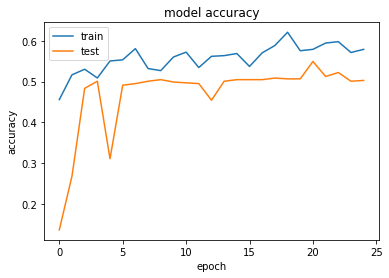

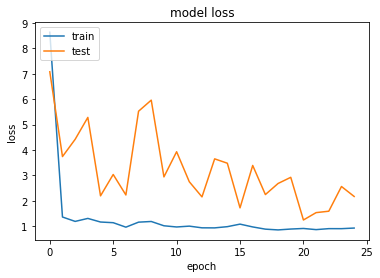

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predictions

In [11]:
test = pd.read_csv('/content/drive/MyDrive/hackaton_deforestation/test.csv')

test

,latitude,longitude,year,example_path
0,0.761681,122.755954,2006,train_test_data/test/69.png
1,-8.059785,113.053791,2007,train_test_data/test/469.png
2,-2.006610,111.746316,2002,train_test_data/test/6.png
3,0.901765,114.042495,2016,train_test_data/test/351.png
4,1.911210,100.829633,2008,train_test_data/test/1001.png
...,...,...,...,...
630,1.650899,101.314723,2011,train_test_data/test/968.png
631,-1.645649,102.612332,2010,train_test_data/test/54.png
632,-0.557796,114.561609,2016,train_test_data/test/494.png
633,-3.037549,113.872045,2009,train_test_data/test/287.png


In [12]:
images_test = []

# Read image
for image_file in test['example_path']:
  path = PATH + image_file
  img = cv2.imread(path)
  images_test.append(img)

In [13]:
test = np.array(images_test)

In [14]:
test.shape

(635, 332, 332, 3)

In [15]:
y_pred = resnet_model.predict(test).argmax(axis=1) # Predict prob and get Class Indices

20/20 [==============================] - 6s 283ms/step


In [20]:
predictions = pd.DataFrame()

predictions['target'] = y_pred

In [21]:
predictions

,target
0,0
1,0
2,0
3,0
4,0
...,...
630,0
631,0
632,0
633,0


In [24]:
result = predictions.to_json()

In [27]:
with open("/content/drive/MyDrive/hackaton_deforestation/predictions.json", "w") as outfile:
    outfile.write(result)